## [天池智慧交通预测挑战赛解决方案](https://github.com/PENGZhaoqing/TimeSeriesPrediction)
 - 作者：PENGZhaoqing
 - 排名：41/1716
 - 最终效果：本地0.267324，线上0.268095
 
### 数据
 - 132条道路
 - 1,0632,044条记录，2016.7,2017.4,2017.5,2017.6月全天数据，2017.7每天6:00-8:00,13:00-15:00,16:00-18:00
 - 预测2017.7每天8:00-9:00,15:00-16:00,18:00-19:00数据

### 分析数据特性
 - 长尾特性，对数据取log(1+x)处理（实际travel_time均大于0）
 - 数据平滑：上阈值95%，下阈值5%
 - 缺失值补全：
   - 季节性趋势：按小时为粒度，取一小时内的travel_time平均值

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.interpolate import UnivariateSpline
import xgboost as xgb

/software/home/chenzh/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
links_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';')
print links_infos.count()
links_infos.head()

link_ID       132
length        132
width         132
link_class    132
dtype: int64


,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


In [4]:
links_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';')
print links_tops.count()
links_tops.head()

link_ID      132
in_links     126
out_links    125
dtype: int64


,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [4]:
df = pd.read_csv('data/quaterfinal_gy_cmp_training_traveltime.txt', delimiter=';')
print df.count()
df.head()

link_ID          10632044
date             10632044
time_interval    10632044
travel_time      10632044
dtype: int64


,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


## 分析数据特性

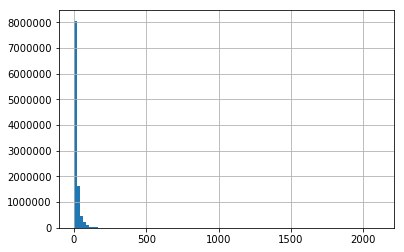

In [5]:
df['travel_time'].hist(bins=100)
plt.show()

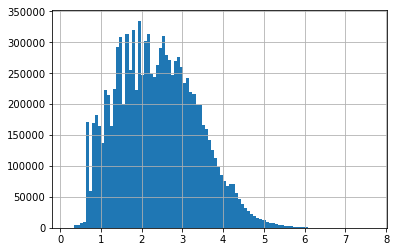

In [6]:
df['travel_time'] = np.log1p(df['travel_time'])  # log(1+x)
df['travel_time'].hist(bins=100)
plt.show()

- 可以看出，travel_time的分布是长尾分布，大部分数据集中在很小的区域，故做log特征变换
- 为避免x=0出现负无穷大，使用log(1+x)

## 数据平滑

In [7]:
def quantile_clip(group):
#     group.plot()
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
#     group.plot()
#     plt.show()
    return group
df['travel_time'] = df.groupby(['link_ID', 'date'])['travel_time'].transform(quantile_clip)

## 缺失值补全

In [9]:
date_list = np.sort(df['date'].unique())  # 查看数据中日期范围
# print date_list  # 2016.07.01-2016.07.31 2017.04.01-2017.07.31
df['time_interval_begin'] = pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))  # 提取出时间2017-05-06 11:04:00

In [100]:
date_range = pd.date_range('2016-07-01 00:00:00', '2016-07-31 23:58:00', freq='2min').append(
    pd.date_range('2017-04-01 00:00:00', '2017-07-31 23:58:00', freq='2min'))

new_index = pd.MultiIndex.from_product([links_infos['link_ID'].unique(), date_range],
                                       names=['link_ID', 'time_interval_begin'])
df_new_index = pd.DataFrame(index=new_index).reset_index()

In [101]:
df_fillna = pd.merge(df_new_index, df, on=['link_ID', 'time_interval_begin'], how='left')

In [141]:
# 预测2017年7月份，8，15，18时的数据
df_select = df_fillna.loc[df_fillna['time_interval_begin'].dt.hour.isin([6,7,8,13,14,15,16,17,18])]  # 筛选出6,7,8,13,14,15,16,17,18小时的数据
df_select = df_select.loc[~(
    (df_select['time_interval_begin'].dt.year == 2017) & 
    (df_select['time_interval_begin'].dt.month == 7) & 
    (df_select['time_interval_begin'].dt.hour.isin([8,15,18]))
)]
df_select['date'] = df_select['time_interval_begin'].dt.strftime('%Y-%m-%d')

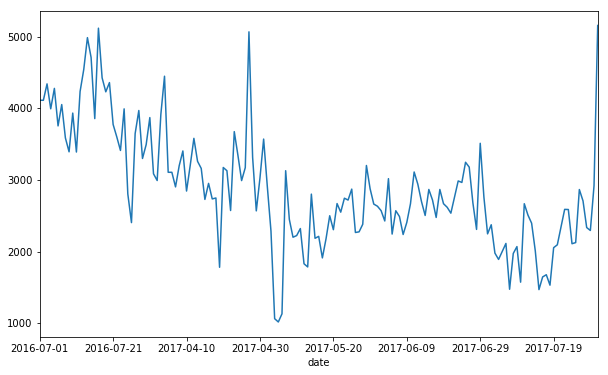

In [144]:
df_select.loc[df_select['travel_time'].isnull() == True].groupby('date')['link_ID'].count().plot(figsize=(10,6))
plt.show()

## 加入2017年3月份的数据，使用3，4，5，6四个月来预测7月
 - df_concat：三四五六七月份数据/13028218
 - df_select：'travel_time'已转换，并做了平滑处理，三四五六七月份，每天6, 7, 8, 13, 14, 15, 16, 17, 18数据/5609962
 - df_fillna：将缺失数据填充为nan，去掉2017.07 8时，15时，18时数据，去掉2017.03.31 数据/4626850/5049000\
 - df_date_daily_trend：计算出两条趋势线，保留travel_time2

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.interpolate import UnivariateSpline
import xgboost as xgb

def quantile_clip(group):
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    return group

# 读取四五六七月数据
df = pd.read_csv('data/quaterfinal_gy_cmp_training_traveltime.txt', delimiter=';', dtype={'link_ID': object})
df['time_interval_begin'] = pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))

# 读取三月数据
df_second = pd.read_csv('data/gy_contest_traveltime_training_data_second.txt', delimiter=';', dtype={'link_ID': object})
df_second = df_second.rename(columns={'linkID': 'link_ID'})
df_second['time_interval_begin'] = pd.to_datetime(df_second['time_interval'].map(lambda x: x[1:20]))
df_second = df_second.loc[(df_second['time_interval_begin'] >= pd.to_datetime('2017-03-01')) & 
                          (df_second['time_interval_begin'] <= pd.to_datetime('2017-03-31'))]
df_concat = pd.concat([df, df_second])
df_concat = df_concat.drop(['time_interval'], axis=1)
'''
save
'''
# 保存三四五六七月份数据
df_concat.to_csv('data/df_concat.txt', header=True, index=None, sep=';', mode='w')
print df_concat.count()

#每天6, 7, 8, 13, 14, 15, 16, 17, 18数据
# df_select = df_concat.loc[(df_concat['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]

df_concat['travel_time'] = np.log1p(df_concat['travel_time'])
df_concat['travel_time'] = df_concat.groupby(['link_ID', 'date'])['travel_time'].transform(quantile_clip)

df_concat = df_concat.loc[(df_concat['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]
'''
save
'''
df_concat.to_csv('data/df_select.txt', header=True, index=None, sep=';', mode='w')

print df_concat.count()
df_concat.head()

link_ID                13028218
date                   13028218
travel_time            13028218
time_interval_begin    13028218
dtype: int64
link_ID                5609962
date                   5609962
travel_time            5609962
time_interval_begin    5609962
dtype: int64


,link_ID,date,travel_time,time_interval_begin
3,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
5,3377906287934510514,2017-05-06,1.887070,2017-05-06 14:36:00
8,3377906287674510514,2017-05-06,1.931521,2017-05-06 06:30:00
14,3377906287886510514,2017-05-06,3.616309,2017-05-06 07:32:00
24,4377906283759500514,2017-05-06,2.140066,2017-05-06 13:24:00


## 填充nan

In [8]:
df_select = pd.read_csv('data/df_select.txt', delimiter=';', 
                        parse_dates=['time_interval_begin'], dtype={'link_ID': object})
links_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
date_range = pd.date_range('2017-03-01 00:00:00', '2017-07-31 23:58:00', freq='2min')
new_index = pd.MultiIndex.from_product([links_infos['link_ID'].unique(), date_range],
                                       names=['link_ID', 'time_interval_begin'])
new_df = pd.DataFrame(index=new_index).reset_index()

df_fillna = pd.merge(new_df, df_select, on=['link_ID', 'time_interval_begin'], how='left')
df_fillna = df_fillna.loc[(df_fillna['time_interval_begin'].dt.hour.isin([6, 7, 8, 13, 14, 15, 16, 17, 18]))]

In [9]:
# 去掉2017.07 8时，15时，18时数据
df_fillna = df_fillna.loc[~(
    (df_fillna['time_interval_begin'].dt.year == 2017) & 
    (df_fillna['time_interval_begin'].dt.month == 7) & 
    (df_fillna['time_interval_begin'].dt.hour.isin([8, 15, 18]))
)]
# 去掉2017.03.31 数据
df_fillna = df_fillna.loc[~(
    (df_fillna['time_interval_begin'].dt.year == 2017) & 
    (df_fillna['time_interval_begin'].dt.month == 3) & 
    (df_fillna['time_interval_begin'].dt.day == 31)
)]

df_fillna['date'] = df_fillna['time_interval_begin'].dt.strftime('%Y-%m-%d')
df_fillna.to_csv('data/df_fillna.txt', header=True, index=None, sep=';', mode='w')

print df_fillna.count()
df_fillna.head()

link_ID                5049000
time_interval_begin    5049000
date                   5049000
travel_time            4626850
dtype: int64


,link_ID,time_interval_begin,date,travel_time
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


## 开始补全
- Seasonal date trend:季节趋势变化线
  - 个别缺失严重路段采用中值作为趋势线
  - 其余路段先计算出每小时的平均值，每个时间点对应一个平均值，使用LR预测缺失数据点的该平均值
  - 最终travel_time减去date_trend
- Daily hour trend：日趋势变化线
 - 当前时间片的历史趋势，计算该时间片的变化趋势
 - 最终travel_time减去date_trend

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/df_fillna.txt', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})
df['travel_time2'] = df['travel_time']

In [71]:
# Seasonal date trend

def date_trend(group):  # 每个group为一条link
    tmp = group.groupby('date_hour').mean().reset_index()  # 每小时travel_time的平均值

    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]

    y = tmp['travel_time'].values  # 列表的形式取出每小时的平均travel_time
    nans, x = nan_helper(y)  # x表示'travel_time'中的非零下标
    # 个别路段缺失严重，采用中值作为趋势线
    if group.link_ID.values[0] in ['3377906282328510514', '3377906283328510514', '4377906280784800514',
                                   '9377906281555510514']:
        tmp['date_trend'] = group['travel_time'].median()
    else:
        regr = linear_model.LinearRegression()
        # LR模型的训练数据
        # X非NAN数据的下表，Y非NAN数据travel_time每小时平均值
        # .reshape(-1, 1)变成列数据
        regr.fit(x(~nans).reshape(-1, 1), y[~nans].reshape(-1, 1))
        tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1, 1)).ravel()  # 降成一维
    
    group = pd.merge(group, tmp[['date_trend', 'date_hour']], on='date_hour', how='left')
#     plt.plot(tmp.index, tmp['date_trend'], 'o', tmp.index, tmp['travel_time'], 'ro')
#     plt.title(group.link_ID.values[0])
#     plt.show()
    return group

df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))  # 2017-03-01-06
df = df.groupby('link_ID').apply(date_trend)
df = df.drop(['date_hour', 'link_ID'], axis=1)
df = df.reset_index()  # 重排以后多出'level_1'列
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['date_trend']

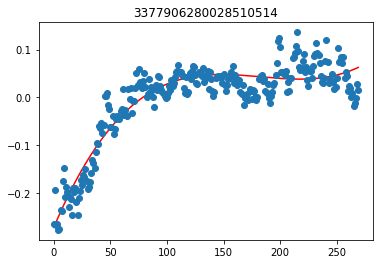

In [62]:
groups = df.groupby('link_ID')
for name, group in groups:
    tmp = group.groupby('hour_minute').mean().reset_index()
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=1, k=3)  # 参数可调整
    tmp['minute_trend'] = spl(tmp.index)
    plt.plot(tmp.index, spl(tmp.index), 'r', tmp.index, tmp['travel_time'], 'o')
    plt.title(group.link_ID.values[0])
    plt.show()
    break

In [72]:
# Daily hour trend
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index()  # 一天分为720时间片，聚集每个时间片
    # k,光滑度；s,Positive smoothing factor used to choose the number of knots.
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=1, k=3)
    tmp['minute_trend'] = spl(tmp.index)
    group = pd.merge(group, tmp[['minute_trend', 'hour_minute']], on='hour_minute', how='left')

    return group

df['hour_minute'] = df.time_interval_begin.map(lambda x: x.strftime('%H-%M'))
df = df.groupby('link_ID').apply(minute_trend)

df = df.drop(['hour_minute', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1', axis=1)
df['travel_time'] = df['travel_time'] - df['minute_trend']

In [73]:
df.to_csv('data/df_date_daily_trend.txt', header=True, index=None, sep=';', mode='w')

In [90]:
df = pd.read_csv('data/df_date_daily_trend.txt', delimiter=';', 
                 parse_dates=['time_interval_begin'], dtype={'link_ID': object})

In [91]:
link_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';', dtype={'link_ID': object})
link_tops['in_links'] = link_tops['in_links'].str.len().apply(lambda x: np.floor(x / 19))  # 计算in_link数
link_tops['out_links'] = link_tops['out_links'].str.len().apply(lambda x: np.floor(x / 19))  # 计算out_link数
link_tops = link_tops.fillna(0)
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')

link_infos['links_num'] = link_infos["in_links"].astype('str') + "," + link_infos["out_links"].astype('str')
link_infos['area'] = link_infos['length'] * link_infos['width']
df = pd.merge(df, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left')

df.loc[df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1

df.loc[~df['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

df['minute'] = df['time_interval_begin'].dt.minute
df['hour'] = df['time_interval_begin'].dt.hour
df['day'] = df['time_interval_begin'].dt.day
df['week_day'] = df['time_interval_begin'].map(lambda x: x.weekday() + 1)
df['month'] = df['time_interval_begin'].dt.month

In [92]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()  # 每条路travel_time的均值
    return group

df = df.groupby('link_ID').apply(mean_time)
sorted_link = np.sort(df['link_ID_en'].unique())  # 计算出所有每天路的平均值，从小到大排序
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))  # link_ID_en值为排序的等级

def std(group):
    group['travel_time_std'] = np.std(group['travel_time'])
    return group

df = df.groupby('link_ID').apply(std)
df['travel_time'] = df['travel_time'] / df['travel_time_std']  # 除以标准差，归一化

In [93]:
df = pd.get_dummies(df, columns=['links_num', 'width', 'minute', 'hour', 'week_day', 'day', 'month'])

In [95]:
feature = df.columns.values.tolist()

train_feature = [x for x in feature if
                     x not in ['link_ID', 'time_interval_begin', 'travel_time', 'date', 'travel_time2', 'minute_trend',
                               'travel_time_std', 'date_trend']]
print train_feature

['length', 'area', 'vacation', 'link_ID_en', 'links_num_0.0,1.0', 'links_num_0.0,2.0', 'links_num_1.0,0.0', 'links_num_1.0,1.0', 'links_num_1.0,2.0', 'links_num_1.0,3.0', 'links_num_1.0,4.0', 'links_num_2.0,0.0', 'links_num_2.0,1.0', 'links_num_2.0,2.0', 'links_num_3.0,1.0', 'links_num_4.0,1.0', 'width_3', 'width_6', 'width_9', 'width_12', 'width_15', 'minute_0', 'minute_2', 'minute_4', 'minute_6', 'minute_8', 'minute_10', 'minute_12', 'minute_14', 'minute_16', 'minute_18', 'minute_20', 'minute_22', 'minute_24', 'minute_26', 'minute_28', 'minute_30', 'minute_32', 'minute_34', 'minute_36', 'minute_38', 'minute_40', 'minute_42', 'minute_44', 'minute_46', 'minute_48', 'minute_50', 'minute_52', 'minute_54', 'minute_56', 'minute_58', 'hour_6', 'hour_7', 'hour_8', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6', 'week_day_7', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day

In [96]:
train_df = df.loc[~df['travel_time'].isnull()]
test_df = df.loc[df['travel_time'].isnull()].copy()

In [97]:
# 填充
params = {
    'learning_rate': 0.2,
    'n_estimators': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 10,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

X = train_df[train_feature].values
y = train_df['travel_time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]
regressor = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             objective='reg:linear', subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'],
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])


regressor.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=eval_set)

test_df['prediction'] = regressor.predict(test_df[train_feature].values)

df = pd.merge(df, test_df[['link_ID', 'time_interval_begin', 'prediction']], on=['link_ID', 'time_interval_begin'],
              how='left')

# feature_vis(regressor,train_feature)

df['imputation1'] = df['travel_time'].isnull()  # 标记是否是填充的缺失值
df['travel_time'] = df['travel_time'].fillna(value=df['prediction'])
df['travel_time'] = (df['travel_time'] * np.array(df['travel_time_std']) + np.array(df['minute_trend'])
                     + np.array(df['date_trend']))

[0]	validation_0-rmse:1.0738
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.04276
[2]	validation_0-rmse:1.02049
[3]	validation_0-rmse:1.00555
[4]	validation_0-rmse:0.99333
[5]	validation_0-rmse:0.985955
[6]	validation_0-rmse:0.980641
[7]	validation_0-rmse:0.976668
[8]	validation_0-rmse:0.974308
[9]	validation_0-rmse:0.971768
[10]	validation_0-rmse:0.96941
[11]	validation_0-rmse:0.966996
[12]	validation_0-rmse:0.965311
[13]	validation_0-rmse:0.963923
[14]	validation_0-rmse:0.962694
[15]	validation_0-rmse:0.961192
[16]	validation_0-rmse:0.960221
[17]	validation_0-rmse:0.959321
[18]	validation_0-rmse:0.95877
[19]	validation_0-rmse:0.958007
[20]	validation_0-rmse:0.95727
[21]	validation_0-rmse:0.956597
[22]	validation_0-rmse:0.955705
[23]	validation_0-rmse:0.955134
[24]	validation_0-rmse:0.954388
[25]	validation_0-rmse:0.953335
[26]	validation_0-rmse:0.952746
[27]	validation_0-rmse:0.952359
[28]	validation_0-rmse:0.952124
[29]	validation_0-rmse:0.9

In [ ]:
def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()

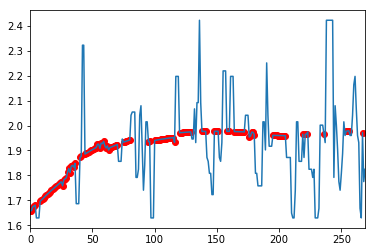

In [103]:
def vis(group):
    group['travel_time'].plot()
    tmp = group.loc[group['imputation1'] == True]
    plt.scatter(tmp.index, tmp['travel_time'], c='r')
    plt.show()
# df.groupby(['link_ID', 'date']).apply(vis)
groups = df.groupby(['link_ID', 'date'])
for name, group in groups:
    group['travel_time'].plot()
    tmp = group.loc[group['imputation1'] == True]
    plt.scatter(tmp.index, tmp['travel_time'], c='r')  # 红色部分为填充的数据
    plt.show()
    break

In [99]:
df[['link_ID', 'date', 'time_interval_begin', 'travel_time', 'imputation1']].to_csv('data/com_training.txt', header=True,
                                                                                        index=None,
                                                                                        sep=';', mode='w')

In [104]:
print df[['travel_time', 'prediction', 'travel_time2']].describe()

        travel_time     prediction  travel_time2
count  5.049000e+06  422150.000000  4.626850e+06
mean   2.417304e+00      -0.008269  2.436141e+00
std    9.455781e-01       0.170118  9.555424e-01
min    3.364722e-01      -1.489307  3.364722e-01
25%    1.667707e+00      -0.078825  1.667707e+00
50%    2.388763e+00      -0.013112  2.415914e+00
75%    3.104587e+00       0.069935  3.135494e+00
max    6.000982e+00       2.927161  6.000982e+00


## 分析提取特征

In [3]:
df = pd.read_csv('data/com_training.txt', delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})

In [4]:
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['time_interval_begin'] = df1['time_interval_begin'] + pd.DateOffset(minutes=i * 2)
    df1 = df1.rename(columns={'travel_time': 'lagging' + str(i)})
    df2 = pd.merge(df, df1[['link_ID', 'time_interval_begin', 'lagging' + str(i)]],
                   on=['link_ID', 'time_interval_begin'],
                   how='left')
    return df2

df1 = create_lagging(df, df, 1)

for i in range(2, 6):
    df1 = create_lagging(df1, df, i)

In [110]:
df1[df1['date'] == '2017-03-06']

,link_ID,date,time_interval_begin,travel_time,imputation1,lagging1,lagging2,lagging3,lagging4,lagging5
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.657881,True,NaN,NaN,NaN,NaN,NaN
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.658394,True,1.657881,NaN,NaN,NaN,NaN
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.672953,True,1.658394,1.657881,NaN,NaN,NaN
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676887,True,1.672953,1.658394,1.657881,NaN,NaN
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.680537,True,1.676887,1.672953,1.658394,1.657881,NaN


In [42]:
# 长、宽特征
link_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';', dtype={'link_ID': object})
link_tops['in_links'] = link_tops['in_links'].str.len().apply(lambda x: np.floor(x / 19))
link_tops['out_links'] = link_tops['out_links'].str.len().apply(lambda x: np.floor(x / 19))
link_tops = link_tops.fillna(0)
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')
link_infos['links_num'] = link_infos["in_links"].astype('str') + "," + link_infos["out_links"].astype('str')
link_infos['area'] = link_infos['length'] * link_infos['width']
df2 = pd.merge(df1, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left')

# links_num feature
df2.loc[df2['links_num'].isin(['0.0,2.0', '2.0,0.0', '1.0,0.0']), 'links_num'] = 'other'
# df.boxplot(by=['links_num'], column='travel_time')
# plt.show()

# vacation feature
df2.loc[df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1
df2.loc[~df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

# minute_series for CV
df2.loc[df2['time_interval_begin'].dt.hour.isin([6, 7, 8]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 6) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([13, 14, 15]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 13) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([16, 17, 18]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 16) * 60

# day_of_week_en feature
df2['day_of_week'] = df2['time_interval_begin'].map(lambda x: x.weekday() + 1)
df2.loc[df2['day_of_week'].isin([1, 2, 3]), 'day_of_week_en'] = 1
df2.loc[df2['day_of_week'].isin([4, 5]), 'day_of_week_en'] = 2
df2.loc[df2['day_of_week'].isin([6, 7]), 'day_of_week_en'] = 3

# hour_en feature
df2.loc[df['time_interval_begin'].dt.hour.isin([6, 7, 8]), 'hour_en'] = 1
df2.loc[df['time_interval_begin'].dt.hour.isin([13, 14, 15]), 'hour_en'] = 2
df2.loc[df['time_interval_begin'].dt.hour.isin([16, 17, 18]), 'hour_en'] = 3

# week_hour feature
df2['week_hour'] = df2["day_of_week_en"].astype('str') + "," + df2["hour_en"].astype('str')

# df2.boxplot(by=['week_hour'], column='travel_time')
# plt.show()

df2 = pd.get_dummies(df2, columns=['week_hour', 'links_num', 'width'])

# ID Label Encode
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

df2 = df2.groupby('link_ID').apply(mean_time)
sorted_link = np.sort(df2['link_ID_en'].unique())
df2['link_ID_en'] = df2['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))
# df.boxplot(by=['link_ID_en'], column='travel_time')
# plt.show()

In [44]:
df2.to_csv(to_file, header=True, index=None, sep=';', mode='w')

## 开始训练

In [5]:
# 长、宽特征
link_infos = pd.read_csv('data/gy_contest_link_info.txt', delimiter=';', dtype={'link_ID': object})
link_tops = pd.read_csv('data/gy_contest_link_top.txt', delimiter=';', dtype={'link_ID': object})
link_tops['in_links'] = link_tops['in_links'].str.len().apply(lambda x: np.floor(x / 19))
link_tops['out_links'] = link_tops['out_links'].str.len().apply(lambda x: np.floor(x / 19))
link_tops = link_tops.fillna(0)
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')
link_infos['links_num'] = link_infos["in_links"].astype('str') + "," + link_infos["out_links"].astype('str')
link_infos['area'] = link_infos['length'] * link_infos['width']
df2 = pd.merge(df1, link_infos[['link_ID', 'length', 'width', 'links_num', 'area']], on=['link_ID'], how='left')

# links_num feature
df2.loc[df2['links_num'].isin(['0.0,2.0', '2.0,0.0', '1.0,0.0']), 'links_num'] = 'other'
# df.boxplot(by=['links_num'], column='travel_time')
# plt.show()

# vacation feature
df2.loc[df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1
df2.loc[~df2['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

# # minute_series for CV
df2.loc[df2['time_interval_begin'].dt.hour.isin([6, 7, 8]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 6) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([13, 14, 15]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 13) * 60

df2.loc[df2['time_interval_begin'].dt.hour.isin([16, 17, 18]), 'minute_series'] = \
    df2['time_interval_begin'].dt.minute + (df2['time_interval_begin'].dt.hour - 16) * 60